[Baseline from Wilson](https://arxiv.org/pdf/2002.08791.pdf)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *

## Data

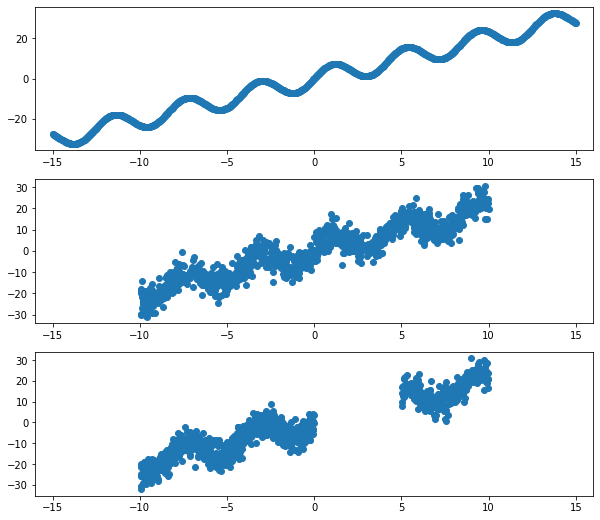

In [3]:
DG = DataGenerator(slope=2.0, amplitude=5.0, frequency=1.5, noise=3.5)

plt.figure(figsize=(10, 9))

plt.subplot(311)
x, y = DG.generate_mean_function(bounds=(-15, 15))
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.subplot(312)
x, y = DG.generate_sample_data(1000)
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.subplot(313)
x, y = DG.generate_sample_data(1000, gap=True)
plt.scatter(x[:, 0], y[:, 0])
plt.xlim(-16, 16)

plt.show()

## Gaussian Process

## MCMC Example

In [4]:
model = BayesianNN()

x, y = DG.generate_sample_data(1000)
model.fit(x, y, 1000)

new_x, new_y = DG.generate_mean_function(bounds=(-15, 15))
posterior = model.sample_posterior(new_x, 500)

Sequential sampling (1 chains in 1 job)
NUTS: [uncertainty, w_b_out, w_2_out, w_b_2, w_1_2, w_b_1, w_in_1]
Sampling chain 0, 0 divergences: 100%|██████████| 1100/1100 [01:25<00:00, 12.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
# ann_input.set_value(new_x)
# ppc = pm.sample_ppc(trace, model=neural_network, samples=500)
# y_pred = ppc["out"].mean(axis=0)[:, None]

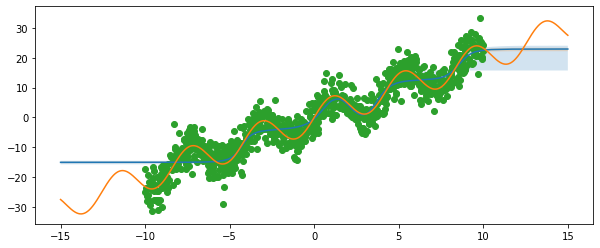

In [6]:
plt.figure(figsize=(10, 4))

MAP = np.percentile(posterior, 50, axis=0)
plt.plot(new_x, MAP)

lb = np.percentile(posterior, 2.5, axis=0)
ub = np.percentile(posterior, 97.5, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

lb = np.percentile(posterior, 20, axis=0)
ub = np.percentile(posterior, 80, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

plt.scatter(x, y)
plt.plot(new_x, new_y)

plt.show()

## VI Example

In [8]:
model = BayesianNN()

x, y = DG.generate_sample_data(100)
model.fit(x, y, 1000, VI=True)

new_x, new_y = DG.generate_mean_function(bounds=(-15, 15))
posterior = model.sample_posterior(new_x, 500)

100%|██████████| 10000/10000 [01:02<00:00, 158.98it/s]


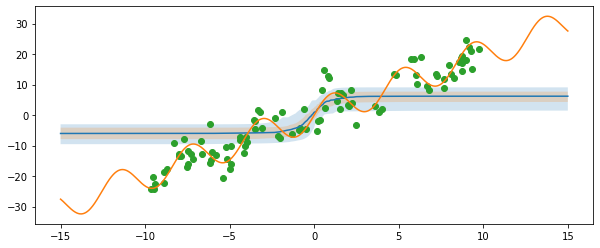

In [9]:
plt.figure(figsize=(10, 4))

MAP = np.percentile(posterior, 50, axis=0)
plt.plot(new_x, MAP)

lb = np.percentile(posterior, 2.5, axis=0)
ub = np.percentile(posterior, 97.5, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

lb = np.percentile(posterior, 20, axis=0)
ub = np.percentile(posterior, 80, axis=0)
plt.fill_between(new_x[:, 0], ub[:, 0], lb[:, 0], alpha=0.2)

plt.scatter(x, y)
plt.plot(new_x, new_y)

plt.show()

## MCDropout Example

## Ensemble Example